In [4]:
import pandas as pd
import numpy as np

# set the seed
np.random.seed(0)

In [5]:
# Load and preprocess data
day_ahead = pd.read_csv('data/Day Ahead Auction Prices.csv')
day_ahead['datetime'] = pd.to_datetime(day_ahead['Date'])
day_ahead.rename(columns={'Day Ahead Auction Price EUR/MWh': 'price'}, inplace=True)
day_ahead = day_ahead[['datetime', 'price']]
day_ahead.set_index('datetime', inplace=True)
# Set hourly frequency for the index to ensure consistent time series data
day_ahead = day_ahead.asfreq('h')

In [6]:
# Split the data into training and testing sets
y_train = day_ahead.loc[:'2023-04-30']
y_test = day_ahead.loc['2023-05-01':]

print("Training data:")
print(y_train.head())
print(y_train.tail())

print("\nTesting data:")
print(y_test.head())
print(y_test.tail())

Training data:
                     price
datetime                  
2016-01-01 00:00:00  23.86
2016-01-01 01:00:00  22.39
2016-01-01 02:00:00  20.59
2016-01-01 03:00:00  16.81
2016-01-01 04:00:00  17.41
                      price
datetime                   
2023-04-30 19:00:00  121.16
2023-04-30 20:00:00  123.60
2023-04-30 21:00:00  122.20
2023-04-30 22:00:00  117.12
2023-04-30 23:00:00  108.71

Testing data:
                      price
datetime                   
2023-05-01 00:00:00  109.90
2023-05-01 01:00:00   99.90
2023-05-01 02:00:00   95.49
2023-05-01 03:00:00   89.98
2023-05-01 04:00:00   87.29
                      price
datetime                   
2024-05-31 19:00:00  107.94
2024-05-31 20:00:00  115.00
2024-05-31 21:00:00  107.91
2024-05-31 22:00:00  101.74
2024-05-31 23:00:00   84.18


In [7]:
from sktime.forecasting.model_selection import ForecastingGridSearchCV, SlidingWindowSplitter
from sktime.performance_metrics.forecasting import MeanSquaredError
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import ForecastingPipeline
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sktime.forecasting.compose import make_reduction
from xgboost import XGBRegressor

# Define forecasting horizon (1 year ahead in hourly steps)
fh = ForecastingHorizon([i for i in range(1, 8761)], is_relative=True)

# Set up cross-validation split for time series using a moving window splitter
cv = SlidingWindowSplitter(fh=[24*365], window_length=24*365, step_length=24*365)

# Set up parameter grid with different strategies
param_grid = {
    'forecaster__estimator__n_estimators': [50, 100],
    'forecaster__estimator__learning_rate': [0.01, 0.1],
    'forecaster__estimator__max_depth': [3, 5, 7],
    'forecaster__estimator__subsample': [0.8, 1.0],
    'forecaster__estimator__colsample_bytree': [0.8, 1.0]
}

# Create a forecasting pipeline with XGBRegressor
pipeline = ForecastingPipeline(
    steps=[
        ("forecaster", make_reduction(XGBRegressor(), window_length=24, strategy="recursive")),
    ]
)

# Create a ForecastingGridSearchCV with MSE as the scoring metric
gscv = ForecastingGridSearchCV(
    forecaster=pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring=MeanSquaredError(), # MAE or MAPE can also be used
    verbose=5,
    error_score='raise'
)

# Fit the model with GridSearchCV
gscv.fit(y_train[['price']], fh=fh)

# Get the best parameters
best_params = gscv.best_params_
best_model = gscv.best_forecaster_

# Print the best model and parameters
print("Best model:", best_model)
print("Best parameters:", best_params)

Fitting 6 folds for each of 48 candidates, totalling 288 fits
Best model: ForecastingPipeline(steps=[('forecaster',
                            RecursiveTabularRegressionForecaster(estimator=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...),
                                                                 w

In [17]:
gscv.cv_results_

mean_test_MeanSquaredError  mean_fit_time  mean_pred_time  \
0                  1670.431531       0.381518        4.624818   
1                  1690.814997       0.363449        4.578005   
2                  1668.252522       0.560131        4.773949   
3                  1680.617176       0.568946        4.832737   
4                  1769.432470       0.712089        4.771929   
5                  1757.737660       0.688354        4.775029   
6                  1754.082889       1.276146        4.858374   
7                  1748.085679       1.255776        4.840452   
8                  1724.425762       1.668882        5.004949   
9                  1732.141008       1.770845        4.989094   
10                 1708.072434       3.341583        5.272683   
11                 1694.152363       3.386825        5.407962   
12                 4046.189483       0.361371        4.959561   
13                 4132.480360       0.382840        4.932871   
14                 4503.552718       0.543444        5.169441   
15                 4151.383228       0.513830        5.203561   
16                 6707.526976       0.705113        5.510281   
17                 2939.999908       0.757421        5.498580   
18                 6603.684009       1.158844        5.529387   
19                 5280.881678       1.179884        5.456538   
20                 5010.589169       1.662361        5.207814   
21                 4487.798945       1.715090        5.149580   
22                 5458.719599       2.485727        4.759868   
23                 6075.761512       2.634330        4.621518   
24                 1679.217698       0.350590        4.172133   
25                 1698.303354       0.346272        4.123294   
26                 1690.314124       0.581603        4.094319   
27                 1686.640512       0.559743        4.112926   
28                 1760.639661       0.764192        4.168482   
29                 1767.706786       0.767800        4.184045   
30                 1755.837495       1.463271        5.000194   
31                 1758.657541       1.488495        5.150747   
32                 1727.394537       1.935462        5.038086   
33                 1736.395501       2.023249        4.999494   
34                 1721.494492       3.879778        5.118830   
35                 1715.093669       4.022551        5.158505   
36                 3782.630195       0.413053        5.048757   
37                 4144.642749       0.468769        5.035343   
38                 4062.104036       0.651350        4.878207   
39                 4811.782623       0.600086        4.906896   
40                 5705.790094       0.776529        4.829246   
41                 5600.976301       0.783201        4.820737   
42                 5166.293711       1.242608        4.808854   
43                 4817.048421       1.281195        4.793495   
44                 6498.891485       1.642237        4.586784   
45                 4178.174833       1.695534        4.546900   
46                 4281.826354       2.589530        4.415598   
47                 4618.954369       2.546612        4.366675   

                                               params  \
0   {'forecaster__estimator__colsample_bytree': 0....   
1   {'forecaster__estimator__colsample_bytree': 0....   
2   {'forecaster__estimator__colsample_bytree': 0....   
3   {'forecaster__estimator__colsample_bytree': 0....   
4   {'forecaster__estimator__colsample_bytree': 0....   
5   {'forecaster__estimator__colsample_bytree': 0....   
6   {'forecaster__estimator__colsample_bytree': 0....   
7   {'forecaster__estimator__colsample_bytree': 0....   
8   {'forecaster__estimator__colsample_bytree': 0....   
9   {'forecaster__estimator__colsample_bytree': 0....   
10  {'forecaster__estimator__colsample_bytree': 0....   
11  {'forecaster__estimator__colsample_bytree': 0....   
12  {'forecaster__estimator__colsample_bytree': 0....   
13  {'forecaster__es

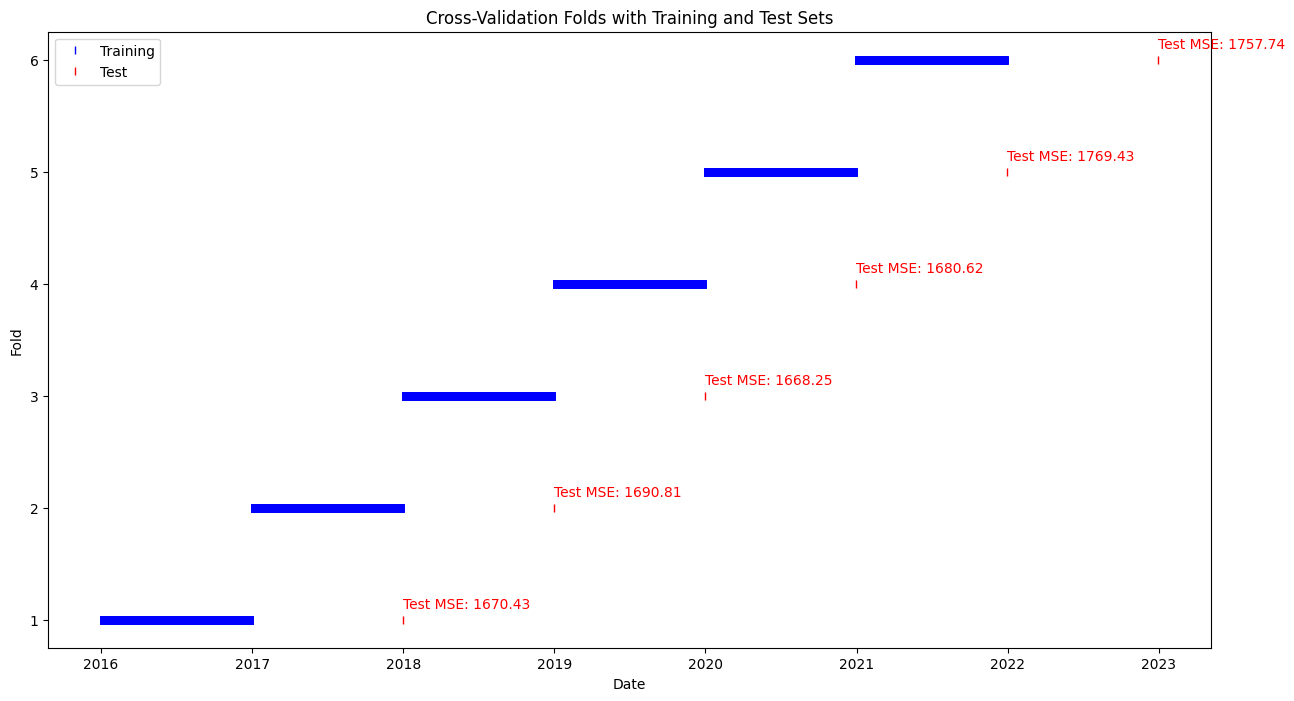

In [18]:
import matplotlib.pyplot as plt

# Extract the splits from the cross-validation object
splits = list(cv.split(y_train))

# Initialize the plot
fig, ax = plt.subplots(figsize=(15, 8))

# Loop through each fold
for i, (train_idx, test_idx) in enumerate(splits):
    # Get the training and test sets for the current fold
    train_dates = y_train.index[train_idx]
    test_dates = y_train.index[test_idx]
    
    # Plot the training and test sets
    ax.plot(train_dates, [i + 1] * len(train_dates), '|', color='blue', label='Training' if i == 0 else "")
    ax.plot(test_dates, [i + 1] * len(test_dates), '|', color='red', label='Test' if i == 0 else "")
    
    # Get the in-sample error from the grid search results
    mse_test_fold = gscv.cv_results_['mean_test_MeanSquaredError'][i]
    
    # Add MAE scores as labels
    ax.text(test_dates[int(len(test_dates) / 2)], i + 1.1, f'Test MSE: {mse_test_fold:.2f}', fontsize=10, color='red')

# Customize the plot
ax.set_xlabel('Date')
ax.set_ylabel('Fold')
ax.set_title('Cross-Validation Folds with Training and Test Sets')
ax.legend()
plt.show()


In [19]:
# Predict in-sample maximum a posteriori estimate
# y_train_pred = best_model.predict(fh=ForecastingHorizon(y_train.index, is_relative=False))
y_pred  = best_model.predict(fh=ForecastingHorizon(y_test.index, is_relative=False))

# # Predict in-sample intervals: 10% and 90% percentiles
# y_train_pred_interval = best_model.predict_interval(coverage=0.9, fh=ForecastingHorizon(y_train.index, is_relative=False))
# y_pred_interval = best_model.predict_interval(coverage=0.9, fh=ForecastingHorizon(y_test.index, is_relative=False))

# y_train_pred_lower = y_train_pred_interval.loc[:, ("price", 0.9, "lower")]
# y_train_pred_upper = y_train_pred_interval.loc[:, ("price", 0.9, "upper")]

# y_pred_lower  = y_pred_interval.loc[:, ("price", 0.9, "lower")]
# y_pred_upper  = y_pred_interval.loc[:, ("price", 0.9, "upper")]

In [20]:
import plotly.graph_objects as go

# Create the interactive plot
fig = go.Figure()

# Add actual values
fig.add_trace(go.Scatter(x=y_train.index, y=y_train['price'], mode='lines', name='y_train'))

# Add predicted values for training set
fig.add_trace(go.Scatter(x=y_train.index, y=y_train_pred['price'], mode='lines', name='y_hat'))

# Add forecasted values for test set
fig.add_trace(go.Scatter(x=y_test.index, y=y_pred['price'], mode='lines', name='y_pred', line=dict(color='orange')))

# Add actual values for test set
fig.add_trace(go.Scatter(x=y_test.index, y=y_test['price'], mode='lines', name='y_test', line=dict(color='lightblue')))

# Add 10% and 90% percentiles for y_train_pred as filled area
fig.add_trace(go.Scatter(
    x=pd.concat([y_train.index.to_series(), y_train.index.to_series()[::-1]]),
    y=pd.concat([y_train_pred_upper, y_train_pred_lower[::-1]]),
    fill='toself',
    fillcolor='rgba(255, 0, 0, 0.2)',
    line=dict(color='rgba(255, 0, 0, 0)'),
    showlegend=True,
    name='y_hat_interval'
))

# Add 10% and 90% percentiles for y_pred
fig.add_trace(go.Scatter(
    x=pd.concat([y_test.index.to_series(), y_test.index.to_series()[::-1]]),
    y=pd.concat([y_pred_upper, y_pred_lower[::-1]]),
    fill='toself',
    fillcolor='rgba(255, 165, 0, 0.2)',
    line=dict(color='rgba(255, 165, 0, 0)'),
    showlegend=True,
    name='y_pred_interval'
))

# Customize the layout
fig.update_layout(
    title='In-sample Fit and Forecast of the Best Grid Search Model',
    xaxis_title='Date',
    yaxis_title='Price',
    hovermode='x unified'
)

# Show the plot
fig.show()

NameError: name 'y_train_pred' is not defined

In [20]:
# Calculate the in-sample and out-of-sample MSE and MAE
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import mean_absolute_error
from sktime.performance_metrics.forecasting import mean_squared_error

# Calculate the in-sample and out-of-sample MSE and MAE
mse_in_sample = mean_squared_error(y_train['price'], y_train_pred['price'])
mae_in_sample = mean_absolute_error(y_train['price'], y_train_pred['price'])
mape_in_sample = mean_absolute_percentage_error(y_train['price'], y_train_pred['price'])

mse_out_sample = mean_squared_error(y_test['price'], y_pred['price'])
mae_out_sample = mean_absolute_error(y_test['price'], y_pred['price'])
mape_out_sample = mean_absolute_percentage_error(y_test['price'], y_pred['price'])

# Show the results in a bar plot
fig = go.Figure(data=[
    go.Bar(name='MSE', x=['In-sample', 'Out-of-sample'], y=[mse_in_sample, mse_out_sample]),
    go.Bar(name='MAE', x=['In-sample', 'Out-of-sample'], y=[mae_in_sample, mae_out_sample]),
    go.Bar(name='MAPE', x=['In-sample', 'Out-of-sample'], y=[mape_in_sample, mape_out_sample])
])

# Customize the layout
fig.update_layout(
    title='In-sample and Out-of-sample Forecasting Performance',
    yaxis_title='Performance',
    barmode='group'
)

# Show the plot
fig.show()

In [21]:
# Calculate residuals for in-sample and out-of-sample predictions
residuals_in_sample = y_train['price'] - y_train_pred['price']
residuals_out_sample = y_test['price'] - y_pred['price']

# Create the interactive plot
fig = go.Figure()

# Add residuals for in-sample
fig.add_trace(go.Scatter(x=y_train.index, y=residuals_in_sample, mode='lines', name='In-sample Residuals', line=dict(color='red')))

# Add residuals for out-of-sample
fig.add_trace(go.Scatter(x=y_test.index, y=residuals_out_sample, mode='lines', name='Out-of-sample Residuals', line=dict(color='orange')))

# Customize the layout
fig.update_layout(
    title='Residuals of the Best Grid Search Model',
    xaxis_title='Date',
    yaxis_title='Residuals',
    hovermode='x unified'
)

# Show the plot
fig.show()

In [36]:
best_model.forecaster_

Prophet(add_country_holidays={'country_name': 'Germany'},
        changepoint_prior_scale=0.1, daily_seasonality=True,
        seasonality_prior_scale=0.01, weekly_seasonality=True,
        yearly_seasonality=True)

In [26]:
# Extract the components from the best model
components = best_model.steps[0][1].predict_components(y_train.index)

# Create the interactive plot
fig = go.Figure()

# Add trend component
fig.add_trace(go.Scatter(x=components.index, y=components['trend'], mode='lines', name='Trend'))

# Add yearly seasonality component
fig.add_trace(go.Scatter(x=components.index, y=components['yearly'], mode='lines', name='Yearly Seasonality'))

# Add weekly seasonality component
fig.add_trace(go.Scatter(x=components.index, y=components['weekly'], mode='lines', name='Weekly Seasonality'))

# Add daily seasonality component
fig.add_trace(go.Scatter(x=components.index, y=components['daily'], mode='lines', name='Daily Seasonality'))

# Customize the layout
fig.update_layout(
    title='Trend, Seasonality, and Other Components of the Best Model',
    xaxis_title='Date',
    yaxis_title='Component Value',
    hovermode='x unified'
)

# Show the plot
fig.show()

AttributeError: 'ForecastingPipeline' object has no attribute 'predict_components'